In [1]:
import numpy as np
import os
import pandas as pd

In [2]:
idx = np.array([179, 250, 223, 349, 348, 295, 285, 249])

In [3]:
test_files = pd.read_csv("test.csv")

In [4]:
import cv2

In [5]:
from matplotlib import pyplot as plt
fnames = list(test_files.iloc[idx].fname)

## Load our Data

In [38]:
import pickle

In [39]:
path = "/export/home/sabraun/_code/nips19/logs/2019-11-13T15-12-44_SB_model_48i_cubsubset_tps/eval/2019-11-14T12-40-11_infer/infer/060000/data.p"
with open(path, "rb") as handle:
    data = pickle.load(handle)

In [40]:
inferred_segmentations = data["outputs"]["out_parts_hard"][idx]

In [41]:
inferred_segmentations.shape

(8, 128, 128)

# Load Our Data

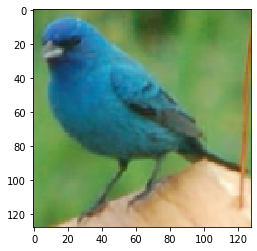

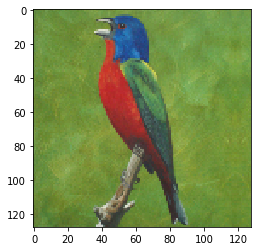

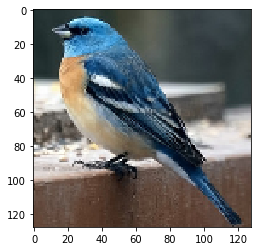

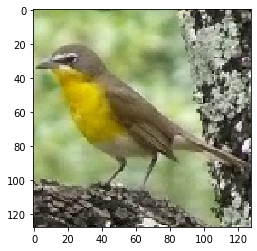

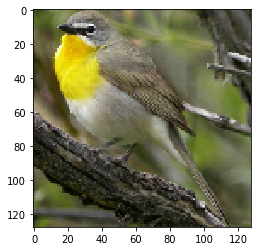

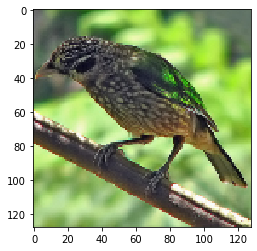

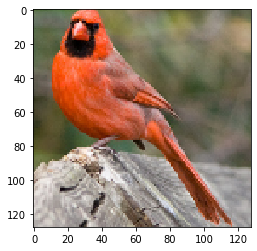

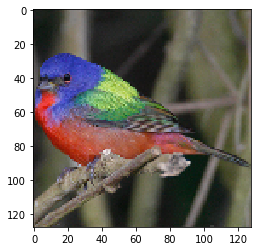

In [42]:
img_batch = []
for fname in test_files.iloc[idx].fname:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    plt.figure()
    plt.imshow(img)
    img_batch.append(img)
img_batch = np.stack(img_batch, axis=0)

## Load segmentations

In [43]:
labelmap = {
    "background" : np.array([0, 0, 0]),
    "head" : np.array([128, 0, 0]),
    "chest" : np.array([0, 128, 0]),
    "wing" : np.array([0, 128, 128]),
    "tail" : np.array([0, 0, 128]),
    "feet" : np.array([128, 0, 128]),
}
def make_flat(sgm, label_map):
    sgm_flat = np.zeros((sgm.shape[:2]))
    for l in labelmap.keys():
        label_mask = np.sum((sgm == labelmap[l]), axis=-1) == 3
        sgm_flat[label_mask] = list(labelmap.keys()).index(l)
    return sgm_flat

# Annotation File 7 does not have feet

In [44]:
img = cv2.imread(fnames[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

segmentation_files = [os.path.join("cub_semantic", "segmentation_mask", "SegmentationClass", f"view_{i}.png") for i in range(8)]
masks_rgb = [cv2.imread(s) for s in segmentation_files]
masks = [make_flat(m, labelmap) for m in masks_rgb]

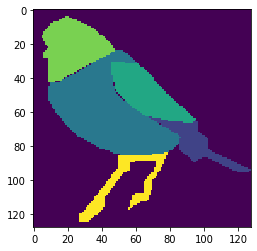

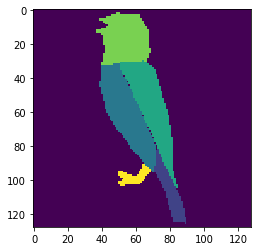

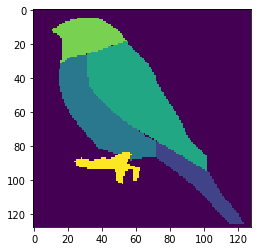

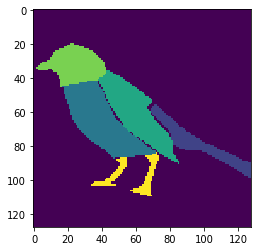

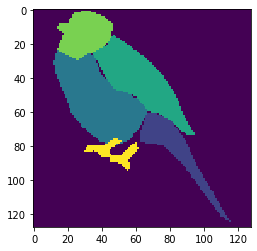

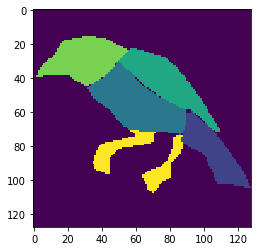

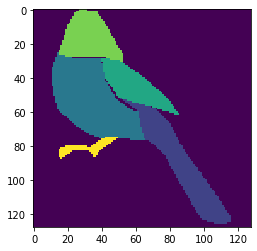

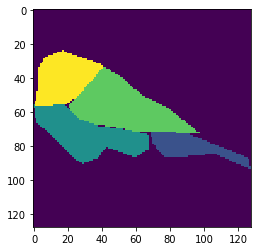

In [45]:
for m in masks:
    plt.figure()
    plt.imshow(m)

# Run CRF ONCE

In [54]:
from supermariopy import crf, denseposelib, imageutils

In [55]:
def get_best_segmentation(
    groundtruth_segmentation, inferred_segmentation
):
    """
    # TODO: document this
    [N, H, W], [N, H, W] 
    
    --> returns [N, H, W], [N, H, W]
    """

    best_remapping = denseposelib.compute_best_iou_remapping(
        inferred_segmentation, groundtruth_segmentation
    )
    remapped_inferred = denseposelib.remap_parts(inferred_segmentation, best_remapping)

    return groundtruth_segmentation, remapped_inferred

## Finally: img batch and keypoints batch

In [56]:
from typing import *
def calculate_iou_df(
    predicted: np.ndarray, target: np.ndarray, label_names: Iterable[str]
):
    """Calculate IOUs for each (predicted, target) pair in tensor `predicted` and `target`
    and each part in label_names.
    Each IOU measurement is written as a line in a dataframe.
    
    If a label is not present in `target`, the IOU is set to -1.
    Parameters
    ----------
    inferred : np.ndarray
        A stack of N inferred labels shaped [N, H, W]
    truth : np.ndarray
        A stack of N target labels shaped [N, H, W]
    label_names : list of `str`
        list of semantic names for each label value
    
    Returns
    -------
    pd.DataFrame
        dataframe with columns [ "batch_idx", label_names[0], ..., label_names[-1] ]
    Examples
    --------
        A = np.ones((10, 10), dtype=np.int)
        B = np.ones((10, 10), dtype=np.int)
        B[:5, :5] = 0
        B[5:, 5:] = 1
        B[5:, :5] = 2
        predicted = np.stack([A] * 10, axis=0)
        target = np.stack([B] * 10, axis=0)
        label_names = ["zeros", "ones", "twos", "threes"]
        df = calculate_iou_df(predicted, target, label_names)
        print(df)
        >>> batch_idx  zeros  ones  twos  threes
        >>>  0.0    0.0   0.5   0.0    -1.0
        >>>  1.0    0.0   0.5   0.0    -1.0
        # ...
    """

    # df = pd.DataFrame(columns=["batch_idx"] + label_names)
    column_names = ["batch_idx"] + label_names
    dtypes = [np.int32] + [np.float32] * len(label_names)
    df = df_empty(column_names, dtypes)
    for batch_idx in range(len(predicted)):
        current_inferred = predicted[batch_idx]
        current_gt = target[batch_idx]
        iou, iou_labels = compute_iou(current_inferred, current_gt)
        df_update = {p: -1.0 for p in label_names}
        df_update.update(
            {
                p: float(np.squeeze(iou[pi == iou_labels]))
                for pi, p in enumerate(label_names)
                if pi in iou_labels
            }
        )
        df_update.update({"batch_idx": batch_idx})
        df = df.append(df_update, ignore_index=True)
    return df

In [57]:
def df_empty(columns, dtypes=None, index=None):
    """create empty dataframe from column names and specified dtypes
    
    Parameters
    ----------
    columns : list
        list of str specifying column names
    dtypes : list of dtypes, optional
        list of dtypes for each column
    index : bool, optional
        [description], by default None
    
    Returns
    -------
    df
        empty pandas dataframe
    Examples
    --------
        df = df_empty(['a', 'b'], dtypes=[np.int64, np.int64])
        print(list(df.dtypes)) # int64, int64
        df = df_empty(['a', 'b'], dtypes=None)
        print(list(df.dtypes)) # float64, float64        
    References
    ----------
        Shamelessly copied from https://stackoverflow.com/questions/36462257/create-empty-dataframe-in-pandas-specifying-column-types
    """
    if dtypes is None:
        dtypes = [None] * len(columns)
    has_consistent_lengths = len(columns) == len(dtypes)
    if not has_consistent_lengths:
        raise ValueError("columns and dtypes have to have same length")
    df = pd.DataFrame(index=index)
    for c, d in zip(columns, dtypes):
        df[c] = pd.Series(dtype=d)
    return df


In [58]:
def compute_iou(pred, label):
    """
    compoute iou between predicted labels and labels. IOU is also called Jaccard Similarity although this is more form the NLP domain.
    pred : ndarray of shape [H, W] and dtype int
        array with predicted labels
    label : ndarray of shape [H, W] and dtype int
        array with ground truth labels
    Returns
    IOU : ndarray of shape [N]
        array with IOUs
    unique_labels : ndarray of shape [n]
        array with unique labels in of GT label array
    """
    unique_labels = np.unique(label)
    num_unique_labels = len(unique_labels)

    I = np.zeros(num_unique_labels)
    U = np.zeros(num_unique_labels)

    for index, val in enumerate(unique_labels):
        pred_i = pred == val
        label_i = label == val

        I[index] = float(np.sum(np.logical_and(label_i, pred_i)))
        U[index] = float(np.sum(np.logical_or(label_i, pred_i)))

    return I / U, unique_labels


def calculate_overall_iou_from_df(
    df: pd.DataFrame,
    exclude_columns: Iterable[str] = ["global_step", "batch_idx", "background"],
) -> pd.DataFrame:
    """calculate overall IOU from a dataframe with IOU values.
    # TODO: the dataframe has to have the following layout
    
    Parameters
    ----------
    df : pd.DataFrame
        dataframe to calculate the IOU of
    exclude_columns: Iterable[str]
        column names to NOT take the mean over
    Examples
    --------
        A = np.ones((10, 10), dtype=np.int)
        B = np.ones((10, 10), dtype=np.int)
        B[:5, :5] = 0
        B[5:, 5:] = 1
        B[5:, :5] = 2
        predicted = np.stack([A] * 10, axis=0)
        target = np.stack([B] * 10, axis=0)
        label_names = ["zeros", "ones", "twos", "threes"]
        df = calculate_iou_df(predicted, target, label_names)
        df_mean = calculate_overall_iou_from_df(df)
        print(df_mean)
        >>> batch_idx  zeros  ones  twos  threes   overall
        >>> 4.5    0.0   0.5   0.0     NaN  0.166667
    
    """

    df_mean = df[df != -1].mean().to_frame().transpose()
    df_mean["overall"] = df_mean[
        filter(lambda x: x not in exclude_columns, df.columns)
    ].mean(axis=1)
    return df_mean

# Rerun again with best parameter and then save labels

In [59]:
groundtruth_segmentation = np.stack(masks, axis=0)

_, remapped_inferred = get_best_segmentation(groundtruth_segmentation, inferred_segmentations)
df = calculate_iou_df(remapped_inferred, groundtruth_segmentation, label_names=list(labelmap.keys()))
df_mean = calculate_overall_iou_from_df(df)
print(df_mean)

batch_idx  background      head     chest      wing      tail      feet  \
0        3.5    0.852199  0.340228  0.565433  0.489071  0.679168  0.153745   

    overall  
0  0.445529  


In [60]:
np.savez_compressed("segments_from_keypoints_ours.npz", remapped_inferred=remapped_inferred)

# Stack GT images together

In [61]:
n_classes = len(labelmap.keys())

In [62]:
colors = imageutils.make_colors(n_classes, with_background=True)

In [63]:
remapped_rgb = colors[remapped_inferred]

In [64]:
import math

In [65]:
def tile(X, rows, cols):
    """Tile images for display.
    
    Parameters
    ----------
    X : np.ndarray
        tensor of images shaped [N, H, W, C]. Images have to be in range [-1, 1]
    rows : int
        number of rows for final canvas
    cols : int
        number of rows for final canvas
    
    Returns
    -------
    np.ndarray
        canvas with images as grid
    """
    tiling = np.zeros((rows * X.shape[1], cols * X.shape[2], X.shape[3]), dtype=X.dtype)
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < X.shape[0]:
                img = X[idx, ...]
                tiling[
                    i * X.shape[1] : (i + 1) * X.shape[1],
                    j * X.shape[2] : (j + 1) * X.shape[2],
                    :,
                ] = img
    return tiling

In [66]:
def batch_to_canvas(X, cols=None):
    """convert batch of images to canvas
    
    Parameters
    ----------
    X : np.ndarray
        tensor of images shaped [N, H, W, C]. Images have to be in range [-1, 1]
    cols : int, optional
        number of columns for the final canvas, by default None
    
    Returns
    -------
    np.ndarray
        canvas with images as grid
    """
    if len(X.shape) == 5:
        # tile
        oldX = np.array(X)
        n_tiles = X.shape[3]
        side = math.ceil(math.sqrt(n_tiles))
        X = np.zeros(
            (oldX.shape[0], oldX.shape[1] * side, oldX.shape[2] * side, oldX.shape[4]),
            dtype=oldX.dtype,
        )
        # cropped images
        for i in range(oldX.shape[0]):
            inx = oldX[i]
            inx = np.transpose(inx, [2, 0, 1, 3])
            X[i] = tile(inx, side, side)
    n_channels = X.shape[3]
    if n_channels > 4:
        X = X[:, :, :, :3]
    if n_channels == 1:
        X = np.tile(X, [1, 1, 1, 3])
    rc = math.sqrt(X.shape[0])
    if cols is None:
        rows = cols = math.ceil(rc)
    else:
        cols = max(1, cols)
        rows = math.ceil(X.shape[0] / cols)
    canvas = tile(X, rows, cols)
    return canvas

In [67]:
remapped_canvas = batch_to_canvas(remapped_rgb, len(remapped_rgb)) * 255.0

In [69]:
cv2.imwrite("remapped_canvas_ours.png", cv2.cvtColor(remapped_canvas.astype(np.uint8), cv2.COLOR_BGR2RGB))

True